# Path planning using Generative Adversarial Network

In this notebook, I employ the concept of Generative Adversarial Network for path planning, i.e., generate paths between two points and classify them to be sure we get the right path.  The idea is to train the GAN based on the training data and later inqure the GAN to generate possible paths between two points. The potential applications of this work would be way finding and navigation for robots and autonomous vehicles. Training data includes different trajectories between 6 pairs of specified points. We treat each trajectory sample as an image. For more information about the data structure and experiment setup see the [dataset description](https://www.kaggle.com/datasets/mehdimka/path-planning).

## Loading packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

import os
import time
from pylab import *

Using TensorFlow backend.


## Loading data
Here we load all csv files into feature and label vectors. Note that all CSV files in the original dataset are zipped in dataset.zip file but when used in kaggle kernels they are unzipped automattically under dataset/dataset folder. 

In [2]:
data_path = "../input/dataset/dataset"

### See how a trajectory data looks like

In [3]:
sample_data = os.path.join(data_path, "00_010.csv")
sample_df = pd.read_csv(sample_data, index_col=None, header=None)
sample_df

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,1,1,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,1,0,0,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0,0
7,0,0,0,0,0,0,0,1,0,0,0,0,0
8,0,0,0,0,0,0,0,1,0,0,0,0,0
9,0,0,0,0,0,0,0,1,0,0,0,0,0


And see how it looks like visually

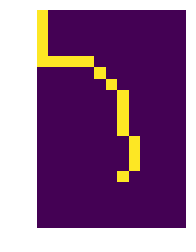

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
plt.imshow(sample_df.values, interpolation='nearest')
plt.axis('off')
plt.show()

Now load all tragectories and identify their labels

In [5]:
def loadData(path=data_path):
    files = os.listdir(path)
    data = []
    labels = []
    for fn in files:
        ffn = os.path.join(path, fn)
        df = pd.read_csv(ffn, index_col=None, header=None)
        df[df==2]=0
        data.append(df.values)
        label = int(fn[0:2])
        labels.append(label)
    data = np.array(data) 
    return data, labels

In [6]:
data, labels = loadData() 

In [7]:
print(labels)

[1, 1, 2, 2, 0, 5, 1, 5, 3, 4, 4, 0, 5, 5, 5, 3, 4, 0, 0, 0, 4, 1, 2, 5, 2, 0, 1, 1, 1, 5, 2, 4, 3, 5, 3, 1, 4, 3, 2, 2, 0, 3, 0, 4, 4, 3, 2, 5, 0, 1, 3, 5, 4, 3, 2, 1, 5, 0, 4, 2, 4, 2, 4, 3, 1, 4, 1, 5, 4, 1, 0, 2, 0, 5, 2, 5, 4, 5, 2, 5, 2, 2, 0, 2, 3, 2, 4, 3, 3, 4, 5, 0, 3, 5, 5, 2, 2, 2, 5, 1, 4, 3, 1, 3, 4, 0, 3, 3, 4, 0, 3, 5, 0, 3, 5, 3, 4, 2, 0, 0, 2, 5, 3, 1, 2, 5, 3, 1, 4, 2, 5, 3, 4, 0, 2, 4, 4, 2, 4, 3, 1, 4, 0, 1, 2, 3, 3, 4, 2, 1, 4, 3, 5, 1, 2, 0, 2, 4, 3, 2, 0, 0, 1, 3, 4, 0, 2, 1, 2, 4, 3, 3, 5, 5, 1, 2, 0, 5, 1, 3, 2, 0, 4, 2, 0, 2, 5, 1, 0, 0, 0, 2, 0, 5, 5, 0, 2, 0, 5, 3, 3, 0, 1, 1, 3, 4, 4, 5, 3, 2, 3, 0, 1, 0, 0, 5, 3, 1, 4, 5, 5, 2, 5, 2, 4, 2, 5, 3, 2, 3, 5, 3, 1, 0, 1, 5, 1, 1, 3, 5, 4, 5, 4, 1, 0, 4, 1, 4, 5, 0, 1, 1, 2, 5, 3, 4, 0, 1, 1, 5, 4, 3, 4, 4, 4, 1, 3, 1, 1, 2, 1, 0, 1, 4, 0, 1, 0, 5, 2, 4, 2, 2, 3, 0, 1, 0, 4, 0, 3, 2, 0, 0, 3, 3, 4, 1, 5, 4, 4, 3, 5, 5, 0, 5, 1, 1, 2, 5, 4, 4, 5, 4, 3]


### Load defined path classes ad their specification:
We have 6 classes. (x1,y1) and (x2,y2) specify tow end of the path.  

In [8]:
defined_path_classes = pd.read_csv("../input/pathClasses.csv", index_col=None)
defined_path_classes

,class,x1,y1,x2,y2
0,0,0,0,14,7
1,1,0,0,16,12
2,2,2,5,16,12
3,3,2,5,16,8
4,4,2,5,18,0
5,5,4,0,10,10


# Create GAN structure

In [9]:
class GAN():
    def __init__(self, img_rows=19, img_cols=13, channels=1):
        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channels = channels
        self.img_shape = (self.img_rows, self.img_cols, self.channels)

        optimizer = Adam(0.0002, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # Build and compile the generator
        self.generator = self.build_generator()
        self.generator.compile(loss='binary_crossentropy', optimizer=optimizer)

        # The generator takes noise as input and generated imgs
        z = Input(shape=(100,))
        img = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The valid takes generated images as input and determines validity
        valid = self.discriminator(img)

        # The combined model  (stacked generator and discriminator) takes
        # noise as input => generates images => determines validity 
        self.combined = Model(z, valid)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def build_generator(self):

        noise_shape = (100,)

        model = Sequential()

        model.add(Dense(256, input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(1024))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Dense(np.prod(self.img_shape), activation='tanh'))
        model.add(Reshape(self.img_shape))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        img_shape = (self.img_rows, self.img_cols, self.channels)

        model = Sequential()

        model.add(Flatten(input_shape=img_shape))
        model.add(Dense(512))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(256))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, X_train, y_, epochs=1000, batch_size=2):

        X_train = 2 * (X_train.astype(np.float32)) - 1
        X_train = np.expand_dims(X_train, axis=3)
        half_batch = int(batch_size / 2)

        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, 100))

            # Generate a half batch of new images
            gen_imgs = self.generator.predict(noise)

            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = np.random.normal(0, 1, (batch_size, 100))

            # The generator wants the discriminator to label the generated samples as valid (ones)
            valid_y = np.array([1] * batch_size)

            # Train the generator
            g_loss = self.combined.train_on_batch(noise, valid_y)

### Build and Train the GAN

In [10]:
gan = GAN()
start_time = time.time()
gan.train(data, labels, epochs=10000, batch_size=8)
print("total training time: %s seconds ---" % (time.time() - start_time))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 247)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               126976    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 258,561
Trainable params: 258,561
Non-trainable params: 0
_________________________________________________________________
____

/opt/conda/lib/python3.6/site-packages/Keras-2.2.4-py3.6.egg/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


total training time: 197.71360206604004 seconds ---


Generate 12 paths from noise vectors of size 100.

In [11]:
gen_samples_row, gen_samples_col = 3,4
count = gen_samples_row*gen_samples_col
noise = np.random.normal(0, 1, (count, 100))
print(noise.shape)

(12, 100)


A noise vector:

In [12]:
noise[0]

array([ 0.79646073, -2.23725461,  0.68810812,  0.33380308,  0.64127182,
       -0.80644527, -0.05885049, -0.82470099, -1.42570095,  1.14636398,
       -0.92931357,  0.14625337, -1.49246267, -0.16189134, -0.18471568,
       -0.77681296, -0.29455471,  0.24475361, -0.24443153, -0.04421801,
       -1.76460013, -0.1070267 ,  1.29509601,  0.91068462,  0.30894917,
       -1.29170434,  0.39671954,  0.78369528, -0.05229147, -1.27789263,
       -0.8334399 ,  0.71829546,  0.59116938, -1.34397045, -1.83617777,
        0.6337429 ,  1.42947436,  0.97041879,  2.47293275,  1.58518517,
        0.96794822,  0.54753354, -1.64296071,  0.92653134, -0.08185655,
        0.15770908,  0.2221284 ,  0.39548018, -0.23068761, -0.24575568,
       -1.0306965 ,  1.35263924, -1.65640887,  1.13495049,  0.01048108,
       -0.99144646, -0.46897825,  0.20930264,  0.56476895, -0.62344118,
       -1.57529753, -1.18288715, -1.38644724, -0.79281343, -0.24392327,
       -0.42394007, -1.29110073,  0.74222238,  1.47351567, -0.57

In [13]:
# Generate images from noise data
gen_imgs = gan.generator.predict(noise)
print(gen_imgs.shape)

(12, 19, 13, 1)


Rescale image pixels in 0 - 1

In [14]:
gen_imgs = 0.5 * gen_imgs + 0.5

Shape of a generated image:

In [15]:
gen_imgs[0].shape

(19, 13, 1)

Show the generated paths

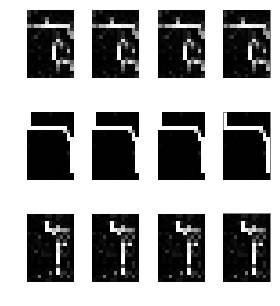

In [16]:
fig, axs = plt.subplots(gen_samples_row, gen_samples_col, figsize=(4.5,5))
cnt = 0
fig.subplots_adjust(hspace=0.5)
for i in range(gen_samples_row):
    for j in range(gen_samples_col):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap=plt.cm.gray)
        axs[i,j].axis('off')
    autoAxis = axs[i,j].axis()
    rec = Rectangle((autoAxis[0]-0.1,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+.2,(autoAxis[3]-autoAxis[2])+0.1,fill=False, lw=0.5)
    rec = axs[i,j].add_patch(rec)
    rec.set_clip_on(False)
    cnt += 1
plt.show()
plt.close()

After generating paths, we need to identify the class of generated path so we can check if they are what we expected.

## Create Path Classifier

In [17]:
class PathClassifier:
    
    def __init__(self, num_pixels=13*19, num_classes=6):
        self.model = self.build_classifier_base(num_pixels, num_classes)

    def build_classifier_base(self, num_pixels, num_classes):
        # fix random seed for reproducibility
        seed = 7
        np.random.seed(seed)
        model = Sequential()
        model.add(Dense(num_pixels, input_dim=num_pixels, kernel_initializer='normal', activation='relu'))
        model.add(Dropout(0.2))
        model.add(Dense(num_classes, kernel_initializer='normal', activation='softmax'))
        # Compile model
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model

    def train_model(self, X_train, y_train, eps=10, batch_size=20):
        num_classes = y_train.shape[1]
        num_pixels = X_train.shape[1]        
        self.model.fit(X_train, y_train, epochs=eps, batch_size=batch_size, verbose=2)
        return self.model

    def evaluate(self, X_test, y_test):        
        scores = self.model.evaluate(X_test, y_test, verbose=0)
        accuracy = scores[1] * 100
        print("Classification accuracy: %.2f%%" % accuracy)
        return accuracy

### Train the path classifier

In [18]:
path_classifier = PathClassifier()
lblEnc = LabelEncoder()
labels = lblEnc.fit_transform(labels)

num_pixels = data.shape[1] * data.shape[2]
data = data.reshape(data.shape[0], num_pixels).astype('float32')
labels = np_utils.to_categorical(labels)

num_classes = labels.shape[1]

lnx = int(len(data) * 0.7)
X_train, X_test = data[:lnx], data[lnx:]
y_train, y_test = labels[:lnx], labels[lnx:]

path_classifier.train_model(X_train, y_train, eps=10, batch_size=i*10)


Epoch 1/10
 - 0s - loss: 1.6325 - acc: 0.4932
Epoch 2/10
 - 0s - loss: 1.2471 - acc: 0.8402
Epoch 3/10
 - 0s - loss: 0.8957 - acc: 0.9224
Epoch 4/10
 - 0s - loss: 0.5911 - acc: 0.9452
Epoch 5/10
 - 0s - loss: 0.3829 - acc: 0.9589
Epoch 6/10
 - 0s - loss: 0.2582 - acc: 0.9726
Epoch 7/10
 - 0s - loss: 0.1833 - acc: 0.9726
Epoch 8/10
 - 0s - loss: 0.1275 - acc: 0.9909
Epoch 9/10
 - 0s - loss: 0.0962 - acc: 0.9909
Epoch 10/10
 - 0s - loss: 0.0791 - acc: 0.9863


How accurate is our path classifier?

In [19]:
path_classifier.evaluate(X_test, y_test)

Classification accuracy: 94.68%


94.68085017610105

Now we can identify the class of generated paths

In [20]:
gen_imgs2 = gen_imgs.reshape(gen_imgs.shape[0], gen_imgs.shape[1]*gen_imgs.shape[2]).astype('float32')
classes = path_classifier.model.predict(gen_imgs2)
classes = np.argmax(classes, axis=1)

Draw generated paths and their class label

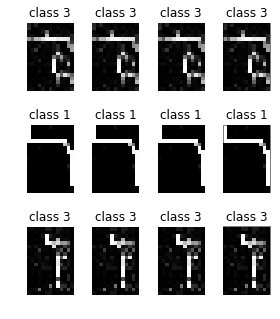

In [21]:
fig, axs = plt.subplots(gen_samples_row, gen_samples_col, figsize=(4.5,5))
cnt = 0
fig.subplots_adjust(hspace=0.5)
for i in range(gen_samples_row):
    for j in range(gen_samples_col):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap=plt.cm.gray)
        axs[i,j].set_title('class ' + str(classes[cnt]))
        axs[i,j].axis('off')
    autoAxis = axs[i,j].axis()
    rec = Rectangle((autoAxis[0]-0.1,autoAxis[2]-0.2),(autoAxis[1]-autoAxis[0])+.2,(autoAxis[3]-autoAxis[2])+0.1,fill=False, lw=0.5)
    rec = axs[i,j].add_patch(rec)
    rec.set_clip_on(False)
    cnt += 1
plt.show()
plt.close()

### *Chanllenge: How to automatically evaluate the accuracy of generative models? It is still an open research question.*